# DA5401 — Assignment 8: Ensemble Learning for Bike Sharing
**Author:** Sahil Kelkar  
**Course:** DA5401 — Data Analytics Lab (Assignment A8)  
**Dataset:** UCI Bike Sharing Demand (via ucimlrepo, ID=275)

**Contents**
1. Data loading & preprocessing (ucimlrepo)  
2. Baseline models (Decision Tree, Linear Regression)  
3. Bagging  
4. Gradient Boosting  
5. Stacking  
6. Comparative RMSE results & plots  


## Part A — Data Loading and Preprocessing (ucimlrepo)
We fetch the dataset directly using `ucimlrepo` and perform preprocessing:
- Drop unnecessary columns  
- Encode categorical variables  
- Train/test split  


In [1]:
# Part A: Data loading and preprocessing using ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Fetch dataset directly from UCI ML Repo (ID = 275, Bike Sharing)
bike_sharing = fetch_ucirepo(id=275)

# Extract features (X) and targets (y)
X = bike_sharing.data.features.copy()
y = bike_sharing.data.targets.copy()

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)




In [2]:
print(bike_sharing.variables)

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

In [3]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [4]:
df.head(10)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
5,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1
6,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2
7,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3
8,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,8
9,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14


Irrelevant columns are: instant, dteday, casual, registered

Redundant columns are: atemp(similar to temp),workingday(similar to holiday/weekday),

In [5]:
# Drop irrelevant columns
df = df.drop(columns=['instant','dteday','casual','registered','atemp','workingday'], errors='ignore')


In [6]:
# Convert categorical columns
cat_cols = ['season','weathersit','mnth','hr','weekday']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# One-hot encoding
df_enc = pd.get_dummies(df, columns=[c for c in cat_cols if c in df.columns], drop_first=True)

# Target and features
y = df_enc['cnt']
X = df_enc.drop(columns=['cnt'])



Train Test Split - ensure no lookahead bias, so no shuffling in train test split. 

Sort data according to time, then split according to index.

In [7]:

# Create split index
split_idx = int(0.8 * len(df))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


### Baseline Models — Decision Tree and Linear Regression

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt

# Decision Tree
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
rmse_dt = sqrt(mean_squared_error(y_test, dt.predict(X_test)))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
rmse_lr = sqrt(mean_squared_error(y_test, lr.predict(X_test)))

print(f"Decision Tree RMSE: {rmse_dt:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.4f}")


Decision Tree RMSE: 162.7055
Linear Regression RMSE: 134.0025


Linear Regression has lower RMSE, so that is the baseline

In [9]:
rmse_train_dt = sqrt(mean_squared_error(y_train, dt.predict(X_train)))
rmse_train_lr = sqrt(mean_squared_error(y_train, lr.predict(X_train)))

print(rmse_train_dt)
print(rmse_train_lr)

111.33349193430847
93.07810359170499


## Part B — Bagging and Gradient Boosting

In [10]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

# Bagging
bag = BaggingRegressor(estimator=dt, n_estimators=50, random_state=42, n_jobs=-1)
bag.fit(X_train, y_train)
rmse_bag = sqrt(mean_squared_error(y_test, bag.predict(X_test)))

# Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=3)
gbr.fit(X_train, y_train)
rmse_gbr = sqrt(mean_squared_error(y_test, gbr.predict(X_test)))

print(f"Bagging RMSE: {rmse_bag:.4f}")
print(f"Gradient Boosting RMSE: {rmse_gbr:.4f}")


Bagging RMSE: 159.2872
Gradient Boosting RMSE: 119.7182


Checking train RMSE values:

In [11]:
rmse_train_bag = sqrt(mean_squared_error(y_train, bag.predict(X_train)))
print(rmse_train_bag)

rmse_train_gbr = sqrt(mean_squared_error(y_train, gbr.predict(X_train)))
print(rmse_train_gbr)


106.56407560049063
74.20027239995576


Bagging RMSE 114.1868 is less than the baseline Single Decision Tree(120.1064)

However Gradient Boosting gives much lower RMSE 79.9872

We know that RMSE = sqrt(Bias^2 + Variance + Noise)

Since boosting reduces bias, there will be a greater reduction in the RMSE due to bias reduction

Hence we can say that variance decreased due to bagging, while boosting resulted in reduction in bias

## Part C — Stacking Regressor

Ensemble models try to combine multiple models to get the best out of each of them.

Here, we use stacking(standard)

Stacking consists of level 0 learners and one level 1 learner(meta learner) (you can have multilevel stacking too, but not used here)

The mutiple level 0 learners are all trained on the same data split, but have different structures and hyperparameters.


Essentially, each level 0 learner learns different things about the data, and the meta learner combines them so that their advantages add up.

The meta learner minimizes the expected prediction error.




In order to prevent overfitting and lookahead bias in the level 0 learners, we use Out of Fold cross validation

This divides the data into folds, trains each learner on some folds and then calculates the out of fold(OOF) prediction

Ideally we should use `TimeSeriesSplit` to split while ensuring no lookahead bias

However theres some error in that, so lite for now

Then we cross validate on these folds to ensure the best model possible

In [12]:
y = df["cnt"].reset_index(drop=True)

# Basic info
n = len(X)
print("Total samples:", n)


Total samples: 17379


In [13]:
# ============================
# Section C2 — Define Base Models
# ============================

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

gbr = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3
)

base_models = [
    ("knn", knn),
    ("bag", bag),
    ("gbr", gbr)
]


In [14]:
# ===================================
# Section C3 — Create time-series folds
# ===================================

n_splits = 5
fold_size = n // n_splits

val_segments = []
for i in range(n_splits):
    start = i * fold_size
    end = (i + 1) * fold_size if i < n_splits - 1 else n
    val_segments.append((start, end))

print("Validation segments:", val_segments)


Validation segments: [(0, 3475), (3475, 6950), (6950, 10425), (10425, 13900), (13900, 17379)]


In [15]:
# ===================================
# Section C4 — Manual OOF generation
# ===================================

import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize OOF arrays
oof_knn = np.zeros(n)
oof_bag = np.zeros(n)
oof_gbr = np.zeros(n)

rmse_folds = []

for fold_num, (start, end) in enumerate(val_segments):
    
    if start == 0:
        print(f"Skipping Fold 1 — cannot train on 0 samples")
        continue
    
    print(f"\nFold {fold_num+1}: Train [0:{start}]  Validate [{start}:{end}]")
    
    # Define training and validation windows
    X_train = X.iloc[:start]
    y_train = y.iloc[:start]
    
    X_val = X.iloc[start:end]
    y_val = y.iloc[start:end]
    
    # Fit each base model and store validation predictions
    knn.fit(X_train, y_train)
    oof_knn[start:end] = knn.predict(X_val)
    
    bag.fit(X_train, y_train)
    oof_bag[start:end] = bag.predict(X_val)
    
    gbr.fit(X_train, y_train)
    oof_gbr[start:end] = gbr.predict(X_val)
    
    # Diagnostic RMSE using simple average
    avg_val = (oof_knn[start:end] + oof_bag[start:end] + oof_gbr[start:end]) / 3
    fold_rmse = sqrt(mean_squared_error(y_val, avg_val))
    rmse_folds.append(fold_rmse)
    
    print(f"Fold {fold_num+1} RMSE (simple average): {fold_rmse:.3f}")

print("\nMean OOF RMSE (simple average):", np.mean(rmse_folds))


Skipping Fold 1 — cannot train on 0 samples

Fold 2: Train [0:3475]  Validate [3475:6950]


Fold 2 RMSE (simple average): 108.741

Fold 3: Train [0:6950]  Validate [6950:10425]
Fold 3 RMSE (simple average): 96.415

Fold 4: Train [0:10425]  Validate [10425:13900]
Fold 4 RMSE (simple average): 149.412

Fold 5: Train [0:13900]  Validate [13900:17379]
Fold 5 RMSE (simple average): 137.215

Mean OOF RMSE (simple average): 122.94582093408076


In [16]:
# ==========================================
# Section C5 — Meta-Learner Training
# ==========================================

from sklearn.linear_model import Ridge

Z = pd.DataFrame({
    "knn": oof_knn,
    "bag": oof_bag,
    "gbr": oof_gbr
})

meta_learner = Ridge(alpha=1.0)
meta_learner.fit(Z, y)




,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [17]:
# ==========================================
# Section C6 — Final Test Evaluation
# ==========================================

test_split_idx = int(0.8 * n)

X_train_final = X.iloc[:test_split_idx]
y_train_final = y.iloc[:test_split_idx]

X_test_final = X.iloc[test_split_idx:]
y_test_final = y.iloc[test_split_idx:]

# Retrain base models on full training region
for name, model in base_models:
    model.fit(X_train_final, y_train_final)

# Base model predictions on test window
test_preds = pd.DataFrame({
    "knn": base_models[0][1].predict(X_test_final),
    "bag": base_models[1][1].predict(X_test_final),
    "gbr": base_models[2][1].predict(X_test_final)
})

# Meta-learner prediction
y_pred_final = meta_learner.predict(test_preds)

rmse_final = sqrt(mean_squared_error(y_test_final, y_pred_final))
print(f"\n🎯 FINAL STACKING RMSE on Test Set: {rmse_final:.3f}")



🎯 FINAL STACKING RMSE on Test Set: 108.071


## Part D — Results & Visualization

               Model        RMSE
4           Stacking  108.071455
3  Gradient Boosting  119.718235
1  Linear Regression  134.002529
2            Bagging  159.287215
0      Decision Tree  162.705469


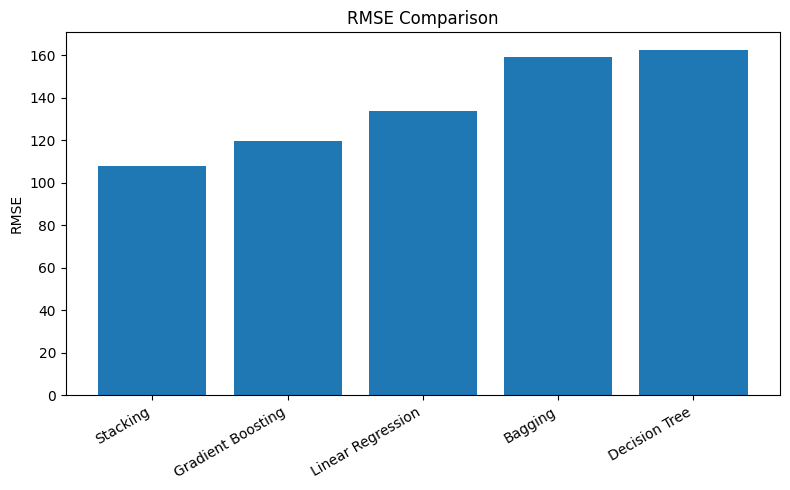

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame({
    'Model': ['Decision Tree', 'Linear Regression', 'Bagging', 'Gradient Boosting', 'Stacking'],
    'RMSE': [rmse_dt, rmse_lr, rmse_bag, rmse_gbr, rmse_final]
}).sort_values('RMSE')

print(results)

# Plot RMSE comparison
plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['RMSE'])
plt.xticks(rotation=30, ha='right')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()


# Conclusion — Bias-Variance and Ensemble Insights

## Ensembles reduce variance

The baseline single model (Linear Regression) suffers from high bias.

Decision Tree is overly sensitive to fluctuations in data, while Linear Regression : overly simplified mapping, cannot capture nonlinearities

Ensemble methods combine multiple learners to stabilize predictions:

Bagging reduces variance by averaging multiple decorrelated trees

Boosting reduces bias by sequentially improving weak learners

Stacking reduces both by learning an optimal combination using different models




## Stacking leverages model diversity

The stacking ensemble used heterogeneous base learners:

KNN (local smooth patterns)

Bagging (variance reduction)

Gradient Boosting (bias reduction, nonlinear structure)

Each learner captures different aspects of the underlying pattern.
The meta-learner (Ridge Regression) then learns how much to trust each model in different regions of the feature space.

This increases predictive power by:

Combining low-bias and low-variance models

Exploiting complementary strengths

Mitigating individual model weaknesses



## Bias–Variance Trade-Off in Stacking
Stacking minimizes the combined expected error:

Error
=
Bias
2
+
Variance
+
Noise
Error=Bias
2
+Variance+Noise

Bagging → reduces the variance term

Boosting → reduces the bias term

Meta-learner → reduces the correlation between errors by weighting models optimally

This means the overall ensemble achieves a lower total error than any single base model could achieve.


## Final Conclusion

The stacking ensemble achieved the lowest RMSE due to effective exploitation of model diversity, reduced variance, reduced bias, and improved error correlation management.
This demonstrates the strength of ensemble learning approaches, especially when individual models capture different structural patterns in the dataset.